In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          storm_surge_forcing, run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# --- Storm surge case: shallow shelf, f-plane, moving cyclone (wind + inverse barometer) ---

Nx, Ny = 128, 96
Lx, Ly = 1.2e6, 8.0e5         # 1200 km x 800 km shelf sea box
grid = make_grid(Nx, Ny, Lx, Ly)

params = ModelParams(
    H=50.0, g=9.81, rho=1025.0,
    f0=1.0e-4, beta=0.0, y0=Ly/2,   # f-plane is fine here
    r=1/(2*86400),                  # ~2-day Rayleigh (crude bottom friction)
    linear=True
)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 4 * 24 * 3600.0                 # 4 days

# Start from rest
ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")

# Moving storm (east-northeast track)
forcing_fn = lambda t, g, p: storm_surge_forcing(
    t, g, p,
    center0=(0.25, 0.30),          # initial position (fraction of domain)
    velocity=(5.0, 2.0),           # m/s (translates across 3 days)
    Vmax=35.0, Rw=8.0e4,           # wind structure
    delta_p=-4.0e3, Rp=1.2e5,      # -40 hPa core, ~120 km e-fold
    use_wind=True, use_pressure=True
)

# Save η and velocities for diagnostics
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=20, out_vars=("eta","u","v"))

print("Saved steps:", len(out["time"]))


Saved steps: 92


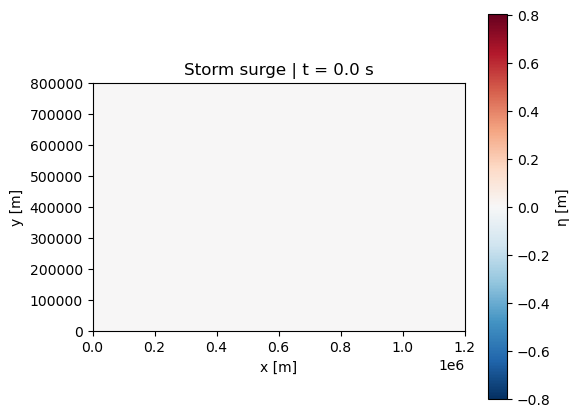

In [6]:
from shallowwater import animate_eta

# Visualize eta(x,y,t) as an animation and display it inline
anim = animate_eta(out, grid, interval=120, title="Storm surge")  # interval in ms

# GIF (no external dependencies)
anim.save("eta_08.gif", fps=10)

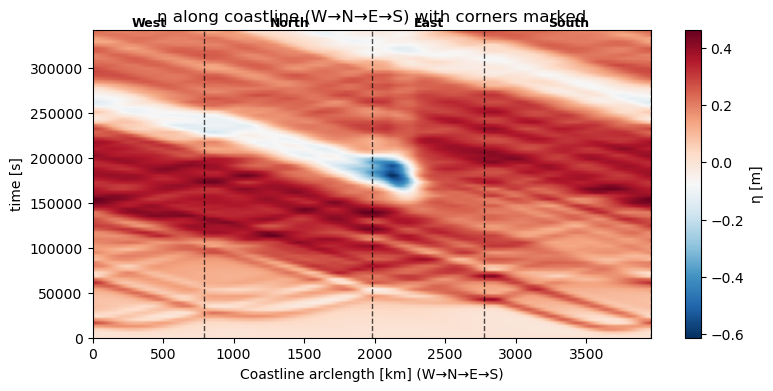

In [7]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")